## Imports

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Initialize functions

## Regression

Mean Squared Error: 1341469.5765277874
R-squared Score: 0.339294223059303
Mean Squared Error: 1158.218276719802


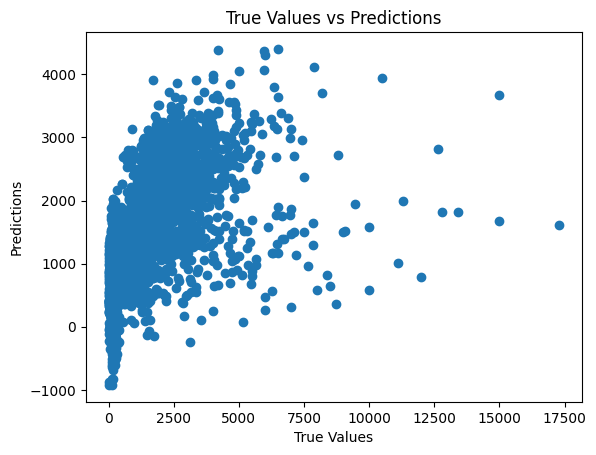

In [11]:
df = pd.read_csv("../preparation/flatfox_clean.csv", low_memory=False)


X = df[["object_category","object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","is_selling_furniture","zipcode","city","latitude","longitude","year_built","year_renovated","moving_date_type","reserved","livingspace"]] 

y = df["price_display"] 


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Initialize the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')



# Plot true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

## Random Forest

In [12]:
# Define features and target
X = df[["object_category","object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","is_selling_furniture","zipcode","city","latitude","longitude","year_built","year_renovated","moving_date_type","reserved","livingspace"]]

y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_built', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_category', 'object_type', 'price_display_type', 'zipcode', 'city', 'moving_date_type', 'is_furnished', 'is_temporary', 'is_selling_furniture'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')



Mean Squared Error: 504146.91597355396
R-squared Score: 0.7516956137963793


C:\Users\lirla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest Hyper Parameter Tuning

In [ ]:
# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Evaluate the best model
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')

# Feature Importances
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
feature_names = (preprocessor.named_transformers_['cat'].get_feature_names_out() + 
                 ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_built', 'year_renovated', 'reserved', 'livingspace'])
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)